## 基础用法

### 初始化模型

In [ ]:
import os
from langchain_openai import ChatOpenAI

os.environ["OPENAI_API_KEY"] = "sk-..."

model = ChatOpenAI(model="gpt-4.1")

response = model.invoke("为什么鹦鹉会说话？")

In [ ]:
import os
from langchain.chat_models import init_chat_model

os.environ["OPENAI_API_KEY"] = "sk-..."

model = init_chat_model("gpt-4.1")

response = model.invoke("为什么鹦鹉会说话？")

## Parameters 参数

In [ ]:
model = init_chat_model(
    "claude-sonnet-4-5-20250929",
    # 传递给模型的参数：
    temperature=0.7,
    timeout=30,
    max_tokens=1000,
)

## Invocation 调用

### Invoke

In [ ]:
response = model.invoke("Why do parrots have colorful feathers?")
print(response)

In [ ]:
conversation = [
    {"role": "system", "content": "您是一个有用的助手，负责将英语翻译成法语。"},
    {"role": "user", "content": "翻译：我喜欢编程。"},
    {"role": "assistant", "content": "J'adore la programmation."},
    {"role": "user", "content": "翻译：我喜欢构建应用程序。"}
]

response = model.invoke(conversation)
print(response)  # AIMessage("J'adore créer des applications.")

In [ ]:
from langchain.messages import HumanMessage, AIMessage, SystemMessage

conversation = [
    SystemMessage("您是一个有用的助手，负责将英语翻译成法语。"),
    HumanMessage("翻译：我喜欢编程。"),
    AIMessage("J'adore la programmation."),
    HumanMessage("翻译：我喜欢构建应用程序。")
]

response = model.invoke(conversation)
print(response)  # AIMessage("J'adore créer des applications.")

### Stream 

In [ ]:
for chunk in model.stream("为什么鹦鹉有彩色的羽毛？"):
    print(chunk.text, end="|", flush=True)

In [ ]:
# 流式传输工具调用、推理和其他内容

for chunk in model.stream("天空是什么颜色？"):
    for block in chunk.content_blocks:
        if block["type"] == "reasoning" and (reasoning := block.get("reasoning")):
            print(f"推理: {reasoning}")
        elif block["type"] == "tool_call_chunk":
            print(f"工具调用块: {block}")
        elif block["type"] == "text":
            print(block["text"])
        else:
            ...

In [ ]:
full = None  # None | AIMessageChunk
for chunk in model.stream("天空是什么颜色？"):
    full = chunk if full is None else full + chunk
    print(full.text)

# 天空
# 天空是
# 天空通常是
# 天空通常是蓝色
# 天空通常是蓝色的
# ...

print(full.content_blocks)
# [{"type": "text", "text": "天空通常是蓝色的..."}]

In [ ]:
# Streaming events 流式事件

async for event in model.astream_events("Hello"):

    if event["event"] == "on_chat_model_start":
        print(f"Input: {event['data']['input']}")

    elif event["event"] == "on_chat_model_stream":
        print(f"Token: {event['data']['chunk'].text}")

    elif event["event"] == "on_chat_model_end":
        print(f"Full message: {event['data']['output'].text}")

    else:
        pass


# Input: Hello
# Token: Hi
# Token:  there
# Token: !
# Token:  How
# Token:  can
# Token:  I
# ...
# Full message: Hi there! How can I help today?

### Batch

- 批处理多个请求可显著提升性能并降低成本，支持并行处理
- 结果可能乱序返回，包含输入索引用于重建原始顺序

In [ ]:
# 默认情况下，batch()只会返回整个批处理的最终输出。
responses = model.batch([
    "为什么鹦鹉有彩色的羽毛？",
    "飞机是如何飞行的？",
    "什么是量子计算？"
])
for response in responses:
    print(response)


# 独立输出结果
for response in model.batch_as_completed([
    "Why do parrots have colorful feathers?",
    "How do airplanes fly?",
    "What is quantum computing?"
]):
    print(response)

#### 设置最大并行数

In [ ]:
# 设置最大并行数

model.batch(
    list_of_inputs,
    config={
        'max_concurrency': 5,  # Limit to 5 parallel calls
    }
)

## Tool calling 工具调用

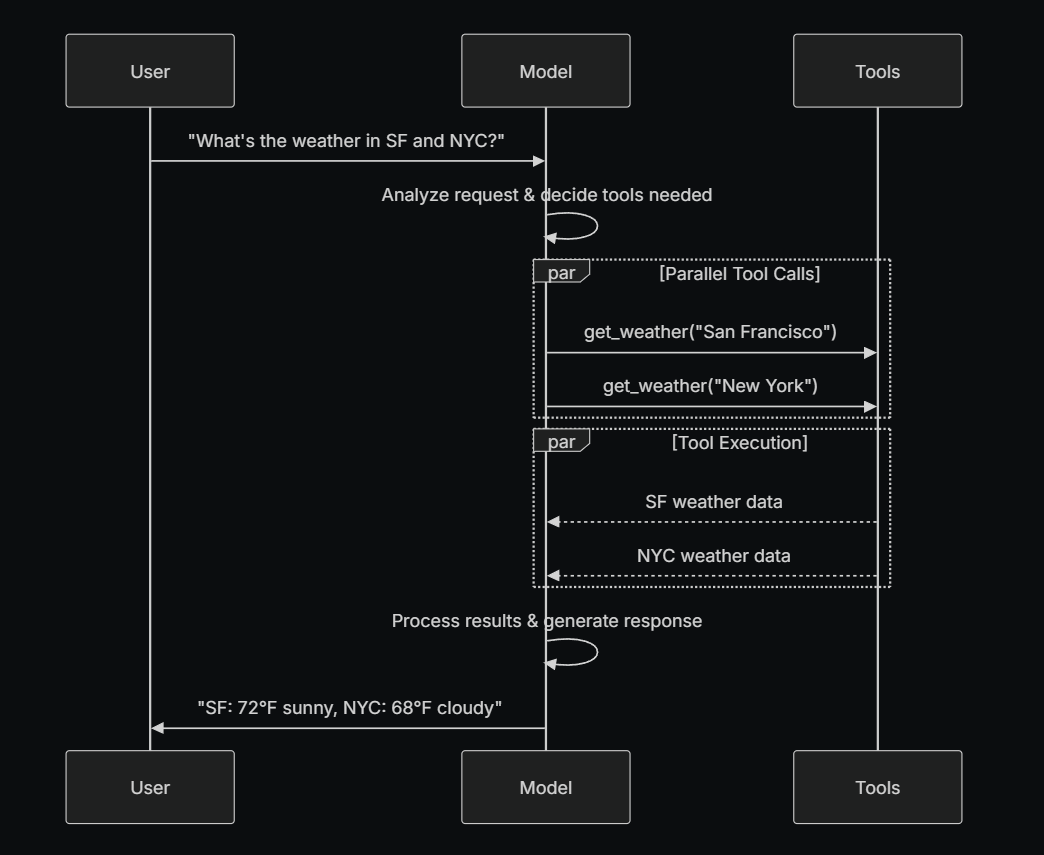

#### Tool execution loop 工具执行循环

In [ ]:
from langchain.tools import tool

@tool
def get_weather(location: str) -> str:
    """获取位置的天气信息。"""
    return f"{location} 天气晴朗。"

# 绑定（可能是多个）工具到模型
model_with_tools = model.bind_tools([get_weather])

# 步骤 1：模型生成工具调用
messages = [{"role": "user", "content": "波士顿的天气怎么样？"}]
ai_msg = model_with_tools.invoke(messages)
messages.append(ai_msg)

# 步骤 2：执行工具并收集结果
for tool_call in ai_msg.tool_calls:
    # 使用生成的参数执行工具
    tool_result = get_weather.invoke(tool_call)
    messages.append(tool_result)

# 步骤 3：将结果传回模型获取最终响应
final_response = model_with_tools.invoke(messages)
print(final_response.text)
# "波士顿当前天气 72°F，晴朗。"

#### Forcing tool calls 强制工具调用

In [ ]:
# 强制使用所有工具
model_with_tools = model.bind_tools([tool_1], tool_choice="any")

# 强制使用指定工具
model_with_tools = model.bind_tools([tool_1], tool_choice="tool_1")

#### 并行工具调用配置

- **默认启用**：多数支持工具调用的模型默认启用并行工具调用
- **选择性禁用**：部分模型允许禁用并行功能（包括OpenAI和Anthropic）
- **设置方法**：通过设置 `parallel_tool_calls=False` 禁用并行工具调用

In [ ]:
model_with_tools = model.bind_tools([get_weather])

response = model_with_tools.invoke(
    "波士顿和东京的天气怎么样？"
)

# 模型可能生成多个工具调用
print(response.tool_calls)
# [
#   {'name': 'get_weather', 'args': {'location': 'Boston'}, 'id': 'call_1'},
#   {'name': 'get_weather', 'args': {'location': 'Tokyo'}, 'id': 'call_2'},
# ]

# 执行所有工具（可以使用异步并行执行）
results = []
for tool_call in response.tool_calls:
    if tool_call['name'] == 'get_weather':
        result = get_weather.invoke(tool_call)
    ...
    results.append(result)

#### Streaming tool calls 流式工具调用


In [ ]:
for chunk in model_with_tools.stream(
    "波士顿和东京的天气怎么样？"
):
    # 工具调用块逐步到达
    for tool_chunk in chunk.tool_call_chunks:
        if name := tool_chunk.get("name"):
            print(f"工具: {name}")
        if id_ := tool_chunk.get("id"):
            print(f"ID: {id_}")
        if args := tool_chunk.get("args"):
            print(f"参数: {args}")

# 输出:
# 工具: get_weather
# ID: call_SvMlU1TVIZugrFLckFE2ceRE
# 参数: {"lo
# 参数: catio
# 参数: n": "B
# 参数: osto
# 参数: n"}
# 工具: get_weather
# ID: call_QMZdy6qInx13oWKE7KhuhOLR
# 参数: {"lo
# 参数: catio
# 参数: n": "T
# 参数: okyo
# 参数: "}

## Structured output 结构化输出

### Pydantic

提供了最丰富的功能集，包括字段验证、描述和嵌套结构。

In [ ]:
from pydantic import BaseModel, Field

class Movie(BaseModel):
    """包含详细信息的电影。"""
    title: str = Field(..., description="电影标题")
    year: int = Field(..., description="电影上映年份")
    director: str = Field(..., description="电影导演")
    rating: float = Field(..., description="电影评分（满分10分）")

model_with_structure = model.with_structured_output(Movie)
response = model_with_structure.invoke("提供电影《盗梦空间》的详细信息")
print(response)  # Movie(title="Inception", year=2010, director="Christopher Nolan", rating=8.8)

### TypedDict

使用Python的内置类型提供了一种更简单的替代方案，非常适合不需要运行时验证的情况。

In [ ]:
from typing_extensions import TypedDict, Annotated

class MovieDict(TypedDict):
    """包含详细信息的电影。"""
    title: Annotated[str, ..., "电影标题"]
    year: Annotated[int, ..., "电影上映年份"]
    director: Annotated[str, ..., "电影导演"]
    rating: Annotated[float, ..., "电影评分（满分10分）"]

model_with_structure = model.with_structured_output(MovieDict)
response = model_with_structure.invoke("提供电影《盗梦空间》的详细信息")
print(response)  # {'title': 'Inception', 'year': 2010, 'director': 'Christopher Nolan', 'rating': 8.8}

### JSON Schema

为了获得最大的控制或互操作性，您可以提供原始JSON模式。

In [ ]:
import json

json_schema = {
    "title": "Movie",
    "description": "包含详细信息的电影",
    "type": "object",
    "properties": {
        "title": {
            "type": "string",
            "description": "电影标题"
        },
        "year": {
            "type": "integer",
            "description": "电影上映年份"
        },
        "director": {
            "type": "string",
            "description": "电影导演"
        },
        "rating": {
            "type": "number",
            "description": "电影评分（满分10分）"
        }
    },
    "required": ["title", "year", "director", "rating"]
}

model_with_structure = model.with_structured_output(
    json_schema,
    method="json_schema",
)
response = model_with_structure.invoke("提供电影《盗梦空间》的详细信息")
print(response)  # {'title': 'Inception', 'year': 2010, ...}

## Advanced topics 高级主题

后面再学